In [18]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt
from FlagRep0 import chordal_distance

import pandas as pd

import seaborn as sns

from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances


In [19]:
# n = 10
# col_ids = [20,20]
# p = np.sum(col_ids)
# hidden_flag_type = [2,4]
# hidden_ms = [2,2]
# noise_exps = range(0,1000,50)
# distributions = ['Normal', 'Exponential', 'Uniform']

# rows = n

# D = []
# hidden_Xs = []
# low_rank_matrices = []
# ProjMat = np.eye(n)
# for i in range(len(hidden_flag_type)):
#     # Set dimensions
#     cols = col_ids[i]

#     # Generate a random matrix of rank < cols
#     # First, create a matrix of lower rank (rank < cols)
#     rank = hidden_ms[i] # Specify the desired rank
#     rand_mat = np.random.randn(rows, rank)
#     hidden_X =  np.linalg.qr(ProjMat @ rand_mat)[0][:,:rank] 
#     ProjMat = np.eye(rows) - hidden_X @ hidden_X.T

#     hidden_Xs.append(hidden_X)
#     low_rank_matrices.append(hidden_X )
    
# for i in range(len(hidden_flag_type)):
#     # Set dimensions
#     cols = col_ids[i]
#     rank = hidden_ms[i] 
#     random_matrix = np.zeros((rows,cols))
#     noise = np.random.normal(size = (rank,cols))
#     for j in range(i+1):
#         random_matrix += low_rank_matrices[j] @ noise

#     D.append(random_matrix)


# D =  np.hstack(D) #+ np.random.normal(size = (n,p), scale = .000001)


In [33]:
n = 10
col_ids = [20,20]
p = np.sum(col_ids)
hidden_flag_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(0,500,50)
distributions = ['Normal', 'Exponential', 'Uniform']


def compute_noise_fraction(noise_exp):
    return .001*noise_exp#10**(-noise_exp)


def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs



def generate_data_noise(noise_fraction, noise_dist, rows, col_ids, noise_type = 'X', verbose = 0):
    D = []
    hidden_Xs = []
    low_rank_matrices = []
    ProjMat = np.eye(n)
    for i in range(len(hidden_flag_type)):
        # Set dimensions
        cols = col_ids[i]

        if noise_dist == 'Normal':
            added_noise = np.random.normal(scale = noise_fraction, size = (rows,p))
        elif noise_dist == 'Exponential':
            added_noise = np.random.exponential(scale = noise_fraction, size = (rows,p))
        elif noise_dist == 'Uniform':
            added_noise = noise_fraction*np.random.uniform(size = (rows,p))


        # Generate a random matrix of rank < cols
        # First, create a matrix of lower rank (rank < cols)
        rank = hidden_ms[i] # Specify the desired rank
        rand_mat = np.random.randn(rows, rank)
        hidden_X =  np.linalg.qr(ProjMat @rand_mat)[0][:,:rank]
        ProjMat = np.eye(rows) - hidden_X @ hidden_X.T
        
        hidden_Xs.append(hidden_X)
        if noise_type == 'X' or noise_type == 'X and D':
            #same nise for all points
            # low_rank_matrix = hidden_X.copy() + added_noise[:,:rank]
            
            # each point gets its own noise
            low_rank_matrix= []
            for _ in range(cols):
                if noise_dist == 'Normal':
                    added_noise = np.random.normal(scale = noise_fraction, size = (rows,p))
                elif noise_dist == 'Exponential':
                    added_noise = np.random.exponential(scale = noise_fraction, size = (rows,p))
                elif noise_dist == 'Uniform':
                    added_noise = noise_fraction*np.random.uniform(size = (rows,p))

                low_rank_matrix0 = hidden_X.copy() + added_noise[:,:rank]
                low_rank_matrix.append(low_rank_matrix0)
        elif noise_type == 'X part':
            low_rank_matrix= []
            for _ in range(cols):
                if i ==0:
                    if noise_dist == 'Normal':
                        added_noise = np.random.normal(scale = noise_fraction, size = (rows,p))
                    elif noise_dist == 'Exponential':
                        added_noise = np.random.exponential(scale = noise_fraction, size = (rows,p))
                    elif noise_dist == 'Uniform':
                        added_noise = noise_fraction*np.random.uniform(size = (rows,p))

                    low_rank_matrix0 = hidden_X.copy() + added_noise[:,:rank]
                else:
                    low_rank_matrix0 = hidden_X.copy()
                low_rank_matrix.append(low_rank_matrix0)
        else:
            low_rank_matrix = hidden_X.copy()

        low_rank_matrices.append(low_rank_matrix)
    
    for i in range(len(hidden_flag_type)):
        # Set dimensions
        cols = col_ids[i]
        rank = hidden_ms[i]
        
        if noise_type in ['X','X and D','X part']:
            random_matrix = np.zeros((rows,cols))
            for ii in range(cols):
                scalar = np.random.normal(size = (rank,1))
                for j in range(i+1):
                    random_matrix[:,[ii]] += low_rank_matrices[j][ii] @  scalar
        else:
            random_matrix = np.zeros((rows,cols))
            scalars = np.random.normal(size = (rank,cols))
            for j in range(i+1):
                random_matrix += low_rank_matrices[j] @ scalars
        if verbose:
            rank_of_matrix = np.linalg.matrix_rank(random_matrix)
            print(f'matrix rank is {rank_of_matrix}')
        D.append(random_matrix)

    if noise_type == 'D' or noise_type == 'X and D':
        D = np.hstack(D) + added_noise
    else:
        D = np.hstack(D)

    if verbose:
        print(D.shape)
        print(f'total shape is {D.shape}, total rank is {np.linalg.matrix_rank(D)}')
        

    return D, hidden_Xs
    

def eval_flagrep(results, D, hidden_Xs, p, noise_fraction, noise_dist, Bs, hidden_flag_type, noise_type):
    # if noise_type == 'D':
    #     #fix the flag type
    #     fl_type = hidden_flag_type
    # else:
    #     fl_type = []
        
    my_flag_rep = FlagRep(Aset = [np.arange(col_ids[0]),np.arange(p)], solver = 'svd', flag_type=[2,4])
    X, R = my_flag_rep.decompose(D)
    if not np.all(my_flag_rep.flag_type() == hidden_flag_type):
        print('Incorrrect flag type detected!')
        print(my_flag_rep.flag_type())
    guess_X0 = [X[:,:hidden_ms[0]],X[:,hidden_ms[0]:]]
    err0 = chordal_distance(np.hstack(guess_X0), np.hstack(hidden_Xs), Bs, Bs)
    rec0 = X @ R
    mse0 = np.sum(np.linalg.norm(rec0 - D, axis = 1)**2)/p
    # mse0 = np.sum(paired_euclidean_distances(rec0, D)**2)/p 
    row = pd.DataFrame(columns = results.columns,
                    data = [['FlagRep', err0, noise_fraction, noise_dist, mse0]])
    results = pd.concat([results, row])

    return results


def eval_svd(results, D, hidden_Xs, p, noise_fraction, noise_dist, Bs, hidden_flag_type):
    U = np.linalg.svd(D)[0][:,:hidden_flag_type[-1]]
    guess_X1 = [U[:,:hidden_ms[0]],U[:,hidden_ms[0]:]]
    err1 = chordal_distance(np.hstack(guess_X1), np.hstack(hidden_Xs), Bs, Bs)
    rec1 = U @ U.T @ D
    mse1 = np.sum(np.linalg.norm(rec1- D, axis = 1)**2)/p 
    # mse1 = np.sum(paired_euclidean_distances(rec1, D)**2)/p 
    row = pd.DataFrame(columns = results.columns,
                    data = [['SVD', err1, noise_fraction, noise_dist, mse1]])
    results = pd.concat([results, row])
    return results


def make_plot(results, title, distributions):

    fig, ax = plt.subplots(3,3)
    fig.suptitle(title)

    for i, noise_dist in enumerate(distributions):
        idx = results['Noise Dist'] == noise_dist
        sns.lineplot(results[idx], x = 'Noise', y = 'Chordal Distance', hue = 'Method', ax = ax[i,0], legend = False)
        ax[0,0].set_title('Chordal Distance')
        ax[i,0].set_ylabel(noise_dist)


        sns.lineplot(results[idx], x = 'Noise', y = 'Reconstruction MSE', hue = 'Method', ax = ax[i,1], legend = False)
        ax[0,1].set_title('Reconstruction MSE')
        ax[i,1].set_ylabel('')
        

        sns.scatterplot(results[idx], x = 'Chordal Distance', y = 'Reconstruction MSE', hue = 'Method', ax = ax[i,2], legend = False, s=1)
        # ax[0,1].set_title('Reconstruction MSE')
        ax[i,1].set_ylabel('')

    plt.tight_layout()

    # plt.yscale('log')

    


/tmp/ipykernel_181384/2771870505.py:136: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])


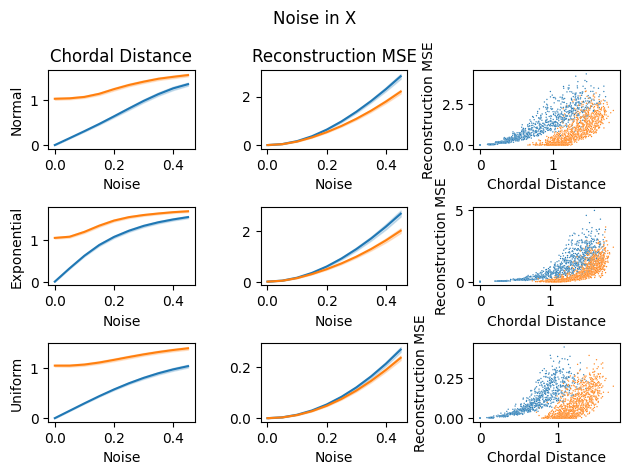

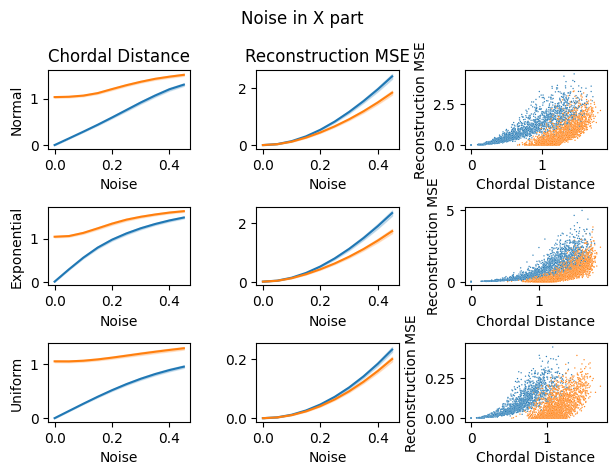

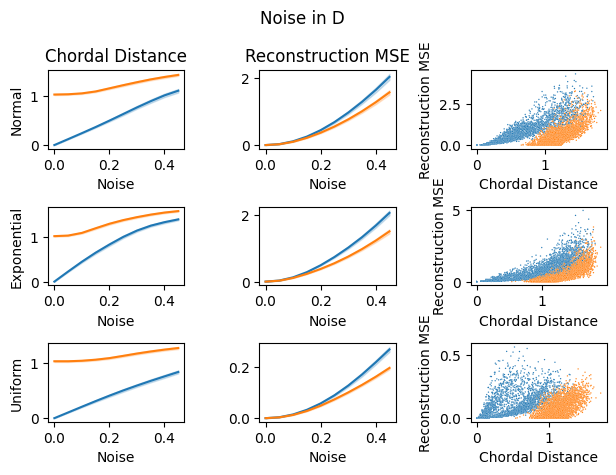

In [34]:

Bs = make_Bs(hidden_flag_type)


results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Noise', 'Noise Dist', 'Reconstruction MSE'])

for noise_type in ['X', 'X part', 'D']:
    for noise_dist in distributions:
        for seed_num in range(100):
            for noise_exp in noise_exps:
                np.random.seed(seed_num)
                noise_fraction = compute_noise_fraction(noise_exp)
                
                D, hidden_Xs = generate_data_noise(noise_fraction, noise_dist, n, col_ids, noise_type = noise_type)

                results = eval_flagrep(results, D, hidden_Xs, p, noise_fraction, noise_dist, Bs, hidden_flag_type, noise_type)

                results = eval_svd(results, D, hidden_Xs, p, noise_fraction, noise_dist, Bs, hidden_flag_type)

    make_plot(results, f'Noise in {noise_type}', distributions)


# plt.yscale('log')


In [16]:
def generate_data_outliers(prop_outliers, n, col_ids, noise_type = 'X', verbose = 0):
    D = []
    hidden_Xs = []
    ProjMat = np.eye(n)
    outlierProjMat = np.eye(n)
    for i in range(len(hidden_flag_type)):
        # Set dimensions
        rows = n
        cols = col_ids[i]

        n_outliers = int(np.floor(prop_outliers*cols))

        # Generate a random matrix of rank < cols
        # First, create a matrix of lower rank (rank < cols)
        rank = hidden_ms[i] # Specify the desired rank
        rand_mat = np.random.randn(rows, rank)
        hidden_X = np.linalg.qr(ProjMat @ rand_mat)[0][:,:rank]
        ProjMat = np.eye(rows) - hidden_X @ hidden_X.T
        
        hidden_Xs.append(hidden_X)

        random_matrix = []
        for _ in range(cols-n_outliers):
            random_matrix.append(hidden_X @ np.random.normal(size = (rank,1)))

        if noise_type == 'X':
            rand_mat = np.random.randn(rows, rank)
            outlier_X =  np.linalg.qr(outlierProjMat @ rand_mat)[0][:,:rank]
            outlierProjMat = np.eye(rows)- outlier_X @ outlier_X.T
            for _ in range(n_outliers):
                random_matrix.append(outlier_X @ np.random.normal(size = (rank,1)))

        elif noise_type == 'D':
            for _ in range(n_outliers):
                random_matrix.append(np.random.normal(size = (n,1)))

        random_matrix = np.hstack(random_matrix)
        

        if verbose:
            # Verify the rank of the matrix
            rank_of_matrix = np.linalg.matrix_rank(random_matrix)
            print(f'matrix rank is {rank_of_matrix}')

        D.append(random_matrix)

    D = np.hstack(D)

    if verbose:
        print(D.shape)
        print(f'total shape is {D.shape}, total rank is {np.linalg.matrix_rank(D)}')
        

    return D, hidden_Xs

/tmp/ipykernel_181384/665258104.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])
/tmp/ipykernel_181384/665258104.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])


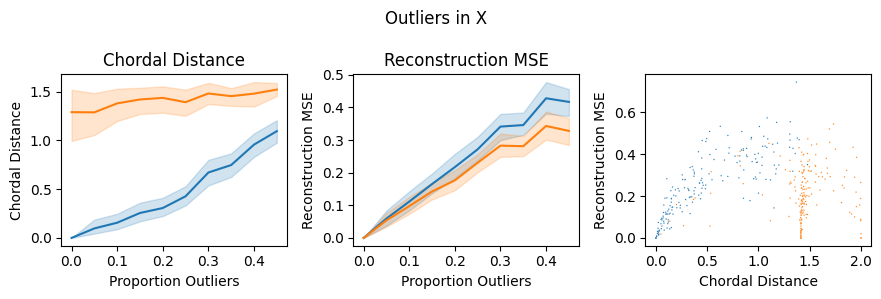

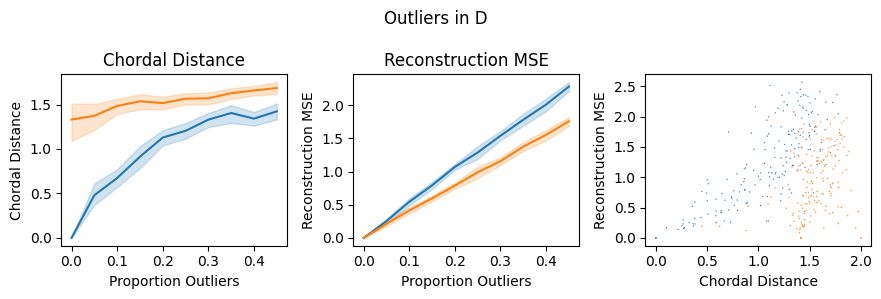

In [17]:

col_ids = [20,20]
outlier_exps = range(10)


def compute_outlier_prop(noise_exp):
    return .05*noise_exp

Bs = make_Bs(hidden_flag_type)


for noise_type in ['X', 'D']:
    results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Noise', 'Noise Dist', 'Reconstruction MSE'])
    for seed_num in range(20):
        for noise_exp in outlier_exps:
            np.random.seed(seed_num)
            prop_outliers = compute_outlier_prop(noise_exp)
            
            D, hidden_Xs = generate_data_outliers(prop_outliers, n, col_ids, noise_type=noise_type, verbose = 0)

            results = eval_flagrep(results, D, hidden_Xs, p, prop_outliers, '', Bs, hidden_flag_type, noise_type)

            results = eval_svd(results, D, hidden_Xs, p, prop_outliers, '', Bs, hidden_flag_type)

    fig, ax = plt.subplots(1,3,  figsize = (9,3))
    fig.suptitle(f'Outliers in {noise_type}')

    results['Proportion Outliers'] = results['Noise'].copy()
    sns.lineplot(results, x = 'Proportion Outliers', y = 'Chordal Distance', hue = 'Method', ax = ax[0], legend = False)
    ax[0].set_title('Chordal Distance')

    sns.lineplot(results, x = 'Proportion Outliers', y = 'Reconstruction MSE', hue = 'Method', ax = ax[1], legend = False)
    ax[1].set_title('Reconstruction MSE')

    sns.scatterplot(results, x = 'Chordal Distance', y = 'Reconstruction MSE', hue = 'Method', ax = ax[2], legend = False, s= 1)
    # ax[1].set_title('Reconstruction MSE')
        

    plt.tight_layout()

    # plt.xscale('log')


# plt.yscale('log')
